### Importing libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import gensim.downloader as gensim_api
import numpy as np
import json

# Load word embeddings
word2vec = gensim_api.load("word2vec-google-news-300")
glove = gensim_api.load("glove-wiki-gigaword-300")
fasttext = gensim_api.load("fasttext-wiki-news-subwords-300")

### Loading Dataset (Json)

In [20]:
with open('../data/ATE_Train.json','r') as f:
    train_json = json.load(f)
with open('../data/ATE_Val.json','r') as f:
    val_json = json.load(f)
with open('../data/ATE_Test.json','r') as f:
    test_json = json.load(f)

In [21]:
def get_embeddings(text, embeddings):
    words = text.split()
    embeddings_list = [embeddings[word] if word in embeddings else np.zeros(embeddings.vector_size) for word in words]
    return torch.tensor(embeddings_list, dtype=torch.float32)

# Convert JSON dataset to numerical format
def get_dataset(word_embedding, json_file, label_mapping):
    numerical_dataset = []
    for key, example in json_file.items():
        text_embeddings = get_embeddings(example["text"], word_embedding)
        label_sequence = torch.tensor([label_mapping[label] for label in example["labels"]], dtype=torch.float32)
        numerical_dataset.append((text_embeddings, label_sequence))
    return numerical_dataset

In [22]:
label_mapping = {"B": 0, "I": 1, "O": 2}
word2vec_train_embeddings = get_dataset(word_embedding=word2vec, json_file=train_json, label_mapping=label_mapping)
word2vec_val_embeddings = get_dataset(word_embedding=word2vec, json_file=val_json, label_mapping=label_mapping)
# glove_embeddings = get_dataset(word_embdeding=glove)
# fasttext_embeddings = get_dataset(word_embdeding=fasttext)

C:\Users\Arjun Mehra\AppData\Local\Temp\ipykernel_3632\2760256805.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(embeddings_list, dtype=torch.float32)


### Models (RNN, LSTM, GRU)

In [23]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

### Train and loss functions

In [36]:

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [34]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def train_model(model, train_data, val_data, criterion, optimizer, num_epochs=5):
    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_data:
            # print(inputs.shape)
            optimizer.zero_grad()
            inputs = inputs.unsqueeze(0)
            
            outputs = model(inputs)
            # print(outputs.shape)
            # print(labels.dtype)
            # print(type(outputs), type(inputs), type(labels))
            
            outputs = outputs.to(torch.float)
            labels = torch.tensor(labels, dtype=torch.long)
            # print(outputs.shape, labels.shape)
            loss = criterion(outputs.view(-1, output_size), labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        predictions = []
        true_labels = []
        with torch.no_grad():
            for inputs, labels in val_data:
                # Add a batch dimension to the inputs
                inputs = inputs.unsqueeze(0)
                outputs = model(inputs)
                labels = torch.tensor(labels, dtype=torch.long)
                val_loss += criterion(outputs.view(-1, output_size), labels)
                _, predicted = torch.max(outputs, 2)
                predictions.extend(predicted.view(-1).cpu().numpy())
                true_labels.extend(labels.view(-1).cpu().numpy())

        val_loss /= len(val_data)
        train_losses.append(loss.item())
        val_losses.append(val_loss)

        # Calculate F1 scores
        train_f1 = f1_score(true_labels, predictions, average='macro')
        val_f1 = f1_score(true_labels, predictions, average='macro')
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, F1 Score: {val_f1:.4f}')

    # Function to plot loss
    def plot_loss(train_losses, val_losses):
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

    # Function to plot F1 score
    def plot_f1_score(train_f1_scores, val_f1_scores):
        plt.plot(range(1, len(train_f1_scores) + 1), train_f1_scores, label='Training F1 Score')
        plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label='Validation F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.title('Training and Validation F1 Score')
        plt.legend()
        plt.show()
    plot_loss(train_losses, val_losses)
    plot_f1_score(train_f1_scores, val_f1_scores)


C:\Users\Arjun Mehra\AppData\Local\Temp\ipykernel_3632\3813339420.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


C:\Users\Arjun Mehra\AppData\Local\Temp\ipykernel_3632\3813339420.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 1/5, Validation Loss: 0.1892, F1 Score: 0.7654


C:\Users\Arjun Mehra\AppData\Local\Temp\ipykernel_3632\3813339420.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
C:\Users\Arjun Mehra\AppData\Local\Temp\ipykernel_3632\3813339420.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 2/5, Validation Loss: 0.1544, F1 Score: 0.7840


C:\Users\Arjun Mehra\AppData\Local\Temp\ipykernel_3632\3813339420.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
C:\Users\Arjun Mehra\AppData\Local\Temp\ipykernel_3632\3813339420.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 3/5, Validation Loss: 0.1440, F1 Score: 0.8024


C:\Users\Arjun Mehra\AppData\Local\Temp\ipykernel_3632\3813339420.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
C:\Users\Arjun Mehra\AppData\Local\Temp\ipykernel_3632\3813339420.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 4/5, Validation Loss: 0.1431, F1 Score: 0.8079


C:\Users\Arjun Mehra\AppData\Local\Temp\ipykernel_3632\3813339420.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
C:\Users\Arjun Mehra\AppData\Local\Temp\ipykernel_3632\3813339420.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 5/5, Validation Loss: 0.1316, F1 Score: 0.8220


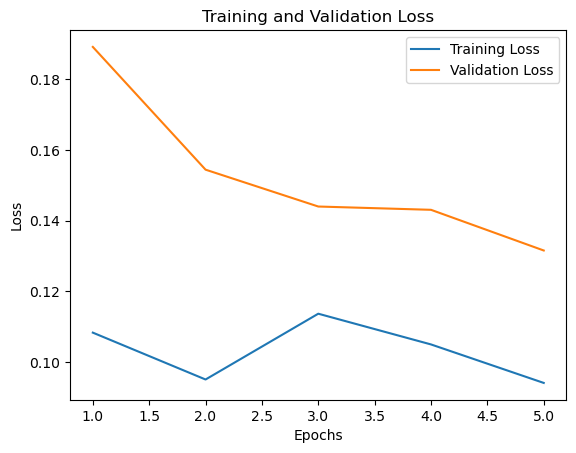

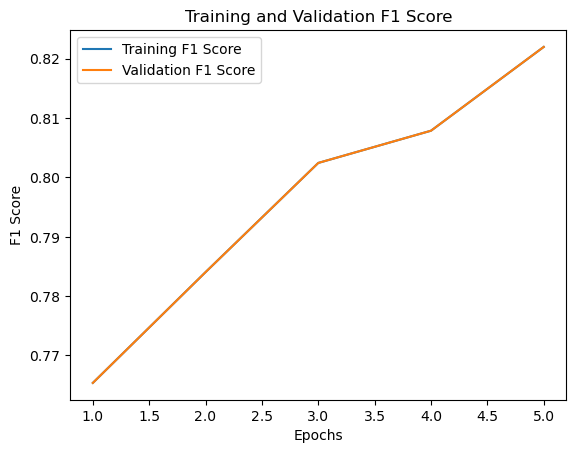

In [35]:
input_size = 300
hidden_size = 128
output_size = 3  # Number of classes (BIO tags)
learning_rate = 0.01

model = VanillaRNN(input_size, hidden_size, output_size)

# # Loop through different embeddings and models
# embeddings = {
#     'word2vec': word2vec,
#     'glove': glove,
#     'fasttext': fasttext
# }
# models = {
#     'vanilla_rnn': VanillaRNNModel,
#     'lstm': LSTMModel,
#     'gru': GRUModel
# }

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, word2vec_train_embeddings, word2vec_val_embeddings, criterion, optimizer, num_epochs=5)

### Training### --------------------------------.

### Calculating F1-score for test dataset

In [ ]:
import torch
from sklearn.metrics import f1_score

def calculate_f1_score(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 2)
            predictions.extend(predicted.view(-1).cpu().numpy())
            true_labels.extend(labels.view(-1).cpu().numpy())
    test_f1 = f1_score(true_labels, predictions, average='macro')
    return test_f1


----------------------------------------------------------------------------- EOF --------------------------------------------------------------------------------